### The idea

The term fake news gained prominence during the last US election, but have been around for a while. The problem is that now they have saturated the media landscape with ever more scandalous titles, and have reached a point where it is difficult to tell the fake from real. They are widely used for political purposes and supposedly shaped the last US elections and are part of the widespread russian hybrid war. 

The goal of this "excercise" is to explore these fake news: Where do they come from? What is in them? What topics get the most involvement? Finally I will try to build a classifier that tries to tell fake from clickbait from real news, and a fake news generator, that will hopefully capture the essence

### Plan of attack 

1. Which media have the most fake news in the dataset?
    Looks like the way the dataset is constructed you get at most 100 titles from a media. So not the best metric        
2. What are the most common words and bigrams you find in titles? 
3. What are the most common words and bigrams you find in texts?
4. What topics get the most interest (likes, shares and comments)?:
    - Need to figure out how to determine topics.
5. Which medias get the most interest (likes, shares and comments)?
6. Can we build fake news classifier:
    - Need to get non-fake-news data.
    - Would it work by title only?
    - Classify fake news, clickbait, real_news
    - T-SNE, clustering and other visualisation. 
    - Word distributions in different groups
    - Deep vs traditional
    - word2vec vs. tf-idf
7. How often do capital letters appear in titles? Can we use these as a predictor?
8. What do the texts of the articles tell us - can we find common patterns, topics, etc.?
9. Can we build a fake news generator?
    - GAN? 
    - RNN or something?
10. Obtain more news to see if the set reflects current state of fake news media. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TODO - Stemming

In [2]:
def make_wordcloud(texts, stopwords, title="Wordcloud", plot=True):
    """
    Helper function that will plot a word cloud from a text or list of texts
    """
    if type(texts) is list:
        texts = ' '.join(texts)
    texts = texts.lower()
    wordcloud = WordCloud(max_font_size=50,
                          background_color="white",
                          max_words=2000,
    
                          stopwords=stopwords).generate(texts)
    if not plot:
        return wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [3]:
stopwords = list(set(stopwords.words('english')))
stopwords.extend(['-', '&', '|', 'hillary', 'clinton', 'trump', 'obama', 'http', 'html','com', 'donald','Hillary', 'also', 'said', 'say',
                  'Obama', 'www', 'infowars', 'infowarsstore'])
sns.set()

In [4]:
# Prepare and clean data
data = pd.read_csv("fake.csv", header=0)
print(set(data.language))
print(set(data.type))
# We want only english on this one. Unfortunately reduces the dataset down to a third of its original size
data = data[data.language == 'english'] 
data = data.dropna()

{'greek', 'dutch', 'italian', 'german', 'norwegian', 'english', 'ignore', 'russian', 'french', 'polish', 'portuguese', 'chinese', 'arabic', 'finnish', 'spanish', 'turkish'}
{'fake', 'bs', 'satire', 'conspiracy', 'state', 'hate', 'bias', 'junksci'}


In [5]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [6]:
satire = data[data.type=='satire']
consp = data[data.type=='conspiracy']
state = data[data.type=='state']
bs = data[data.type=='bs']
bias = data[data.type=='bias']
fake = data[data.type=='fake']
junksci = data[data.type=='junksci']
hate = data[data.type=='hate']


### Dataset type composition

By far the most news are the ones labelled as 'bs'. Seems that this category is a throw it all that features a lot of data that would otherwise be in another category. Biased news, conspiracy theories, hate news and junkscience follow. Now the question here is how much does this distributon capture what is actually out there and is there a way to get an idea for that? I will try to come back to that later.

[('fake', 2), ('bs', 3737), ('conspiracy', 163), ('state', 6), ('hate', 99), ('bias', 271), ('junksci', 97)]


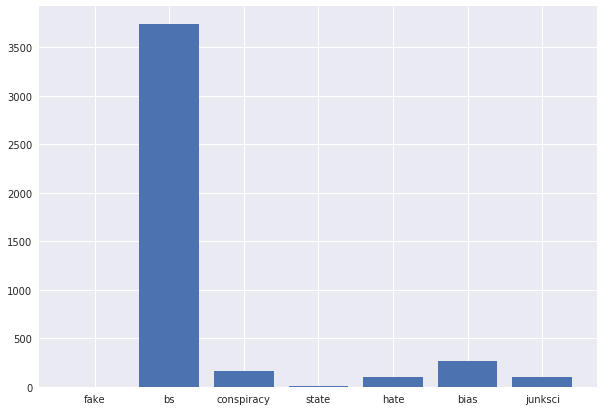

In [7]:
types = set(data.type)
sizes = []
for t in types:
    sizes.append((t, data[data.type==t].shape[0]))
print(sizes)

plt.figure(figsize=[10,7])
plt.bar(left = [x for x in range(len(types))], height = [x[1] for x in sizes])
plt.xticks([x for x in range(len(types))], [x[0] for x in sizes])
plt.show()

### Wordclouds

Lets have a look at the wordclouds of the texts of the news in the major categories. 
Initially all clouds had the names of the presidential candidates as well as former president Obama feature prominently.
So, I added them to the stopwords, to see what else is there. 

At a first glance most wordclouds feature some of the same prominent words, yet have their own slant. The junk
science news seem to stand on its own, as it features a lot more health related words. Most other 'fake news'
seem to be overly political. 

It seems there is quite the little marketing campaign going on in conspiracy. Might also be the case that most of those news come exclusively from infowars. 

Next step would be comparing word distributions and trying to do PCAs, clustering, etc. 



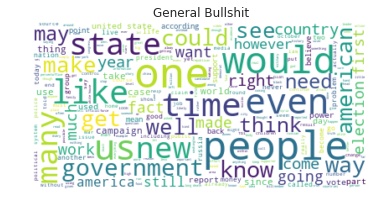

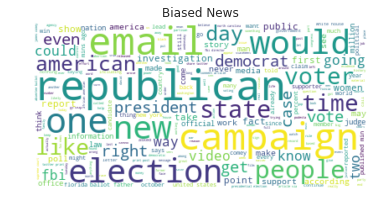

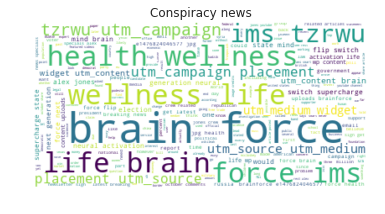

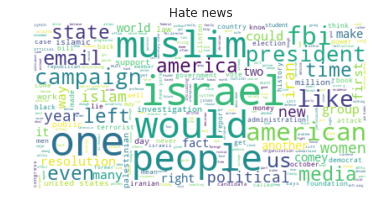

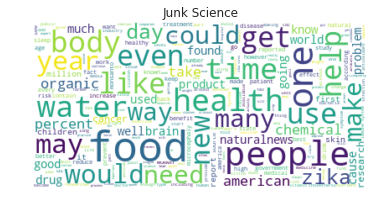

In [8]:
# 1. With and without names
# 2. texts and titles
make_wordcloud(list(bs.text), stopwords, "General Bullshit")
make_wordcloud(list(bias.text), stopwords, "Biased News")
make_wordcloud(list(consp.text), stopwords, "Conspiracy news")
make_wordcloud(list(hate.text), stopwords, "Hate news")
make_wordcloud(list(junksci.text), stopwords, "Junk Science")

#TODO Put all in one graph. 

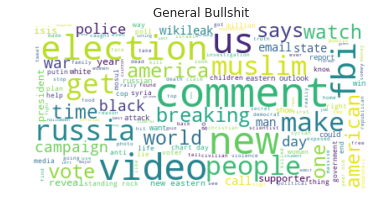

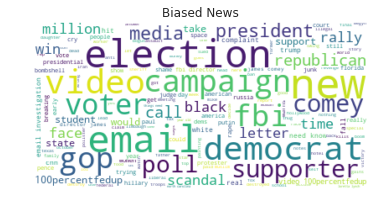

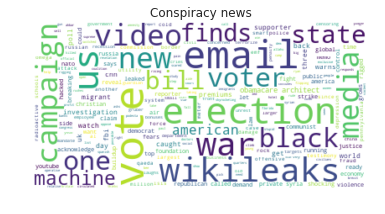

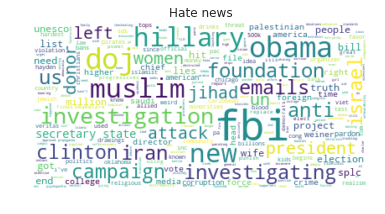

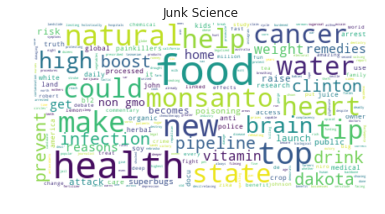

In [9]:
make_wordcloud(list(bs.title), stopwords, "General Bullshit")
make_wordcloud(list(bias.title), stopwords, "Biased News")
make_wordcloud(list(consp.title), stopwords, "Conspiracy news")
make_wordcloud(list(hate.title), stopwords, "Hate news")
make_wordcloud(list(junksci.title), stopwords, "Junk Science")

In [10]:
# likes and shares. 
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]

#shared_data_counts = shared_data_counts[ (shared_data_counts.likes>0) | (shared_data_counts.shares > 0)]
#share_data_counts
shared_data.head()

,uuid,site_url,likes,shares,comments
0,6a175f46bcd24d39b3e962ad0f29936721db70db,100percentfedup.com,0,0,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,100percentfedup.com,0,0,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,100percentfedup.com,0,0,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,100percentfedup.com,0,0,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,100percentfedup.com,0,0,0


Index(['likes', 'shares', 'comments'], dtype='object')


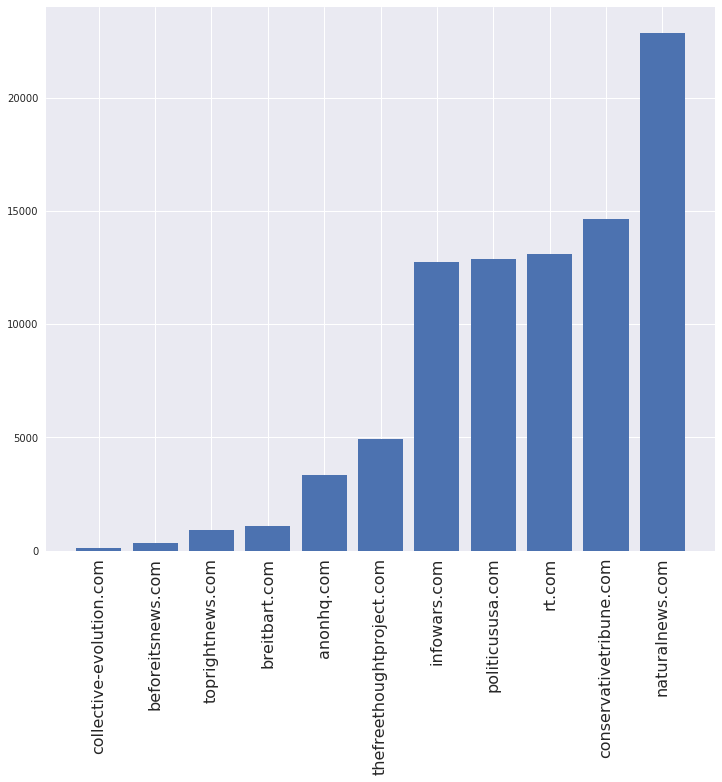

In [11]:
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()

In [12]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), stopwords = stopwords, token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()

TypeError: __init__() got an unexpected keyword argument 'stopwords'

Overall I don't think the topics given in the type column in the dataset are very good. 
Next Im going to try extracting a new set of topics, as described over here: 
http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py in sci-kit learn. 

###